In [1]:
include("./tools.jl")
using Plots
colorbar = cgrad(:linear_tritanopic_krjcw_5_98_c46_n256, rev = true);

  1.707719 seconds (716.75 k allocations: 790.237 MiB, 3.53% gc time)


  6.570079 seconds (64.92 M allocations: 15.618 GiB, 16.09% gc time)


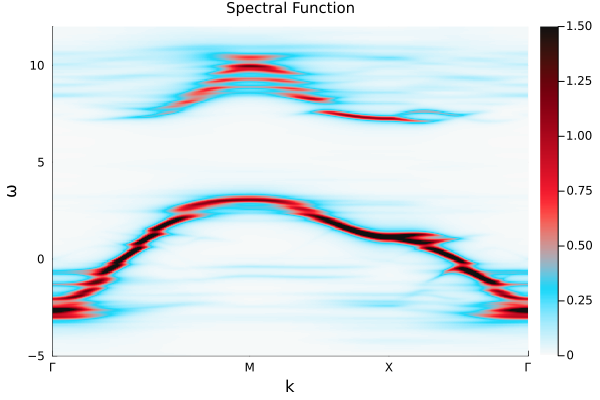

In [36]:
unitcell = Lattice([0, 0]; vectors=[[1, 0], [0, 1]])
cluster = Lattice(unitcell, (4,2), ('p','p'))
hilbert = Hilbert(site=>Fock{:f}(1, 2) for site=1:length(cluster))
bs = Sector(hilbert, ParticleNumber(6))
t = Hopping(:t, -1.0, 1)
t2 = Hopping(:t2, 0.0, 1)
U = Hubbard(:U, 8.0)
μ = Onsite(:μ, -0.0)
μ_r = Onsite(:μ_r, -0.0)
origiterms = (t,t2 , U, μ)
referterms = (t,t2 , U, μ_r)
neighbors = Neighbors(0=>0.0, 1=>1.0, 2=>√2)
@time vca = VCA(:N, unitcell, cluster, hilbert, origiterms, referterms, bs; m=300)
k_path = ReciprocalPath(reciprocals(unitcell.vectors), rectangle"Γ-M-X-Γ", length=300)
ω_range = range(-5, 12, length=300)
@time G = singleParticleGreenFunction(:f, vca, k_path, ω_range;η=0.10)
A = spectrum(G)
f = plot(k_path, ω_range, A; xlabel="k", ylabel="ω", color=colorbar, title="Spectral Function",clims=(0, 1.5))

In [37]:
spawn(3)
@everywhere begin
    include("./tools.jl")
    unitcell = Lattice([0, 0]; vectors=[[1, 0],[0, 1]])
    cluster = Lattice(unitcell,(4,2),('p','p'))
    hilbert = Hilbert(site=>Fock{:f}(1, 2) for site=1:length(cluster))
    bs = Sector(hilbert, ParticleNumber(6))
    t = Hopping(:t, -1.0, 1)
    U = Hubbard(:U, 8.0)
    μ = Onsite(:μ, -1.0)
    origiterms = (t, U, μ)
    t_r = Hopping(:t, -1.0, 1)
    μ_r = Onsite(:μ_r, -1.0)
    referterms = (t_r, U, μ_r)
    neighbors = Neighbors(0=>0.0, 1=>1.0)
    rz = ReciprocalZone(reciprocals(cluster.vectors); length=100)
    vca = VCA(:N, unitcell, cluster, hilbert, origiterms, referterms, bs; neighbors=neighbors, m=200)
    gps(x) = GrandPotential((μ=x[1],), (μ_r=x[2],), :f, vca, rz, 0.0)
    els(x) = OrderParameters((μ=x[1],), (μ_r=x[2],), :f, vca, rz, 0.0)
    M = range(-1.0, -0.8, 3)
    options = Optim.Options(x_tol=1e-4, f_tol=1e-6, iterations=100)
end
res = pmap(m -> optimize(x->-gps([m, x...]), [-2.0], options), M)
mus = [re.minimizer for re in res]

In [ ]:
ops = pmap(i->OrderParameters((μ=M[i],), (μ_r=mus[i][1],), :f, vca,hilbert, rz, μ, 0.0), 1:3)